In [1]:
import time
import datetime

import numpy as np
import pandas as pd
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import *
from keras.layers.wrappers import *
from keras.optimizers import RMSprop
from keras.callbacks import CSVLogger, EarlyStopping
import keras.backend.tensorflow_backend as ktf

import matplotlib.pyplot as plt

from common import *

plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['axes.facecolor'] = 'w'
plt.rcParams['axes.labelcolor'] = 'k'
plt.rcParams['axes.edgecolor'] = 'k'
plt.rcParams['ytick.color'] = 'k'
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['grid.color'] = (.7, .7, .7, 0)
plt.rcParams['figure.figsize'] = (16, 10)

print('numpy ver.: ' + np.__version__)
print('pandas ver.: ' + pd.__version__)
print('tensorflow ver.: ' + tf.__version__) 
print('keras ver.: ' + keras.__version__)

Using TensorFlow backend.


numpy ver.: 1.13.1
pandas ver.: 0.19.0
tensorflow ver.: 1.0.0
keras ver.: 2.0.8


In [2]:
def get_session(gpu_fraction=1):
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction,
                                allow_growth=True)
    return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

ktf.set_session(get_session())

## Functions

### Functions for generate data

In [3]:
def build_model(input_timesteps, output_timesteps, num_links):
    model = Sequential()
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, num_links, 1, 1)))
    model.add(ConvLSTM2D(name ='conv_lstm_1',
                         filters = 64, kernel_size = (10, 1),                       
                         padding = 'same', 
                         return_sequences = True))
    
    model.add(Dropout(0.2, name = 'dropout_1'))
    model.add(BatchNormalization(name = 'batch_norm_1'))

    model.add(ConvLSTM2D(name ='conv_lstm_2',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = False))
    
    model.add(Dropout(0.1, name = 'dropout_2'))
    model.add(BatchNormalization(name = 'batch_norm_2'))
    
    model.add(Flatten())
    model.add(RepeatVector(output_timesteps))
    model.add(Reshape((output_timesteps, num_links, 1, 64)))
    
    model.add(ConvLSTM2D(name ='conv_lstm_3',
                         filters = 64, kernel_size = (10, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(Dropout(0.1, name = 'dropout_3'))
    model.add(BatchNormalization(name = 'batch_norm_3'))
    
    model.add(ConvLSTM2D(name ='conv_lstm_4',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
    #model.add(Dense(units=1, name = 'dense_2'))

    optimizer = RMSprop() #lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.9)
    model.compile(loss = "mse", optimizer = optimizer)
    return model

In [4]:
def info(msg):
    print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S') + " " + msg)

## Load data

In [5]:
data = prep_data('../data/4A_1_201705_201710.csv')
print(len(data))

1213677


Subset the part of the 4A line that are identical across all journey patterns.

In [6]:
data = data[(1 <= data['LineDirectionLinkOrder']) & (data['LineDirectionLinkOrder'] <= 32)]
data = data[data['LinkTravelTime'].notnull()]
assert len(data['LinkRef'].unique()) == 32
n = len(data)
print(n)

920684


## Train and test

In [7]:
global_start_time = time.time()
early_stopping = EarlyStopping(monitor='val_loss', patience = 3)

bootstrap_size_pct = 0.80
test_window_pct = 0.05
max_iter = 4

lags = 4 * 8
preds = 3

hist = []
for i in range(max_iter):

    info("Current window: " + str(i))
    
    # Devide into test and train
    data_train = data[:int((bootstrap_size_pct + i * test_window_pct) * n)]
    data_test = data[int((bootstrap_size_pct + i * test_window_pct) * n):int((bootstrap_size_pct + (i + 1) * test_window_pct) * n)]
    n_train = len(data_train)
    n_test = len(data_test)
    info('- Train size : {:>8} ({:.2f}%) '.format(n_train, 100. * n_train / n))
    info('- Test size  : {:>8} ({:.2f}%) '.format(n_test, 100. * n_test / n))
    
    # Mean center and scale
    (means, scales, low, upr) = fit_scale(data_train)
    assert means.shape == (4 * 24 * 7, 32)
    assert len(scales) == 32
    assert low.shape == (4 * 24 * 7, 32)
    assert upr.shape == (4 * 24 * 7, 32)
    
    data_train_no = data_train
    data_test_no = data_test
    #data_train_no, n_outliers = remove_outliers(data_train, low, upr)
    #info('- Removed {0} outliers ({1:.2f}%) from train'.format(n_outliers, 100.0 * n_outliers / len(data_train)))
    #data_test_no, n_outliers = remove_outliers(data_test, low, upr)
    #info('- Removed {0} outliers ({1:.2f}%) from test'.format(n_outliers, 100.0 * n_outliers / len(data_test)))
    
    ix_train, ts_train, rm_mean_train, rm_scale_train, w_train, lns_train = transform(data_train_no, means, scales)
    ix_test, ts_test, rm_mean_test, rm_scale_test, w_test, lns_test = transform(data_test_no, means, scales)

    # Create rolling window tensor
    X_train, Y_train, Y_ix_train, Y_rm_mean_train, Y_scale_train, Y_w_train = roll(ix_train, ts_train, rm_mean_train, rm_scale_train, w_train, lags, preds)
    X_test, Y_test, Y_ix_test, Y_rm_mean_test, Y_scale_test, Y_w_test = roll(ix_test, ts_test, rm_mean_test, rm_scale_test, w_test, lags, preds)

    X_train = X_train[:,:,:,np.newaxis,np.newaxis]
    Y_train = Y_train[:,:,:,np.newaxis,np.newaxis]
    X_test = X_test[:,:,:,np.newaxis,np.newaxis]
    Y_test = Y_test[:,:,:,np.newaxis,np.newaxis]
    
    info('- X_train shape : {:>20}    X_test shape : {:>20}'.format(X_train.shape, X_test.shape))
    info('- Y_train shape : {:>20}    Y_test shape : {:>20}'.format(Y_train.shape, Y_test.shape))
    
    model = build_model(lags, preds, len(lns_train))
    
    # Train
    history = model.fit(X_train, Y_train,
                        batch_size = 128, epochs = 30,
                        shuffle = False, validation_data = (X_test, Y_test),
                        verbose = 2) #, callbacks = [csv_logger, early_stopping])
    hist.append(history)
    model.save('models/ConvLSTM_3x15min_10x64-5x64-10x64-5x64_' + str(i) + '.h5') 

    Y_true = Y_test.squeeze() * Y_scale_test + Y_rm_mean_test
    Y_naive = Y_rm_mean_test
    Y_pred = model.predict(X_test).squeeze() * Y_scale_test + Y_rm_mean_test
        
    Y_true_total = np.sum(Y_true * Y_w_test, axis = 2).squeeze()
    Y_naive_total = np.sum(Y_naive * Y_w_test, axis = 2).squeeze()
    Y_pred_total = np.sum(Y_pred * Y_w_test, axis = 2).squeeze()
    
    for t in range(preds):
        mask = Y_true_total[:,t] > 0
        Y_true_total_t = Y_true_total[mask, t] / 60
        Y_naive_total_t = Y_naive_total[mask, t] / 60
        Y_pred_total_t = Y_pred_total[mask, t] / 60  

        error_naive_total_t = (Y_naive_total_t - Y_true_total_t)
        error_lstm_total_t = (Y_pred_total_t - Y_true_total_t)

        mae_ha = np.mean(np.abs(error_naive_total_t))
        rmse_ha = np.sqrt(np.mean((error_naive_total_t)**2))
        mape_ha = np.mean(np.abs(error_naive_total_t) / Y_true_total_t) * 100

        mae_lstm = np.mean(np.abs(error_lstm_total_t))
        rmse_lstm = np.sqrt(np.mean((error_lstm_total_t)**2))
        mape_lstm = np.mean(np.abs(error_lstm_total_t) / Y_true_total_t) * 100
        
        info("- t + %d - HA       - MAE: %5.2f - RMSE: %5.2f - MAPE: %5.2f" % (t + 1, mae_ha, rmse_ha, mape_ha))
        info("- t + %d - ConvLSTM - MAE: %5.2f - RMSE: %5.2f - MAPE: %5.2f" % (t + 1, mae_lstm, rmse_lstm, mape_lstm))
        info("- t + %d - *        - MAE: %5.2f - RMSE: %5.2f - MAPE: %5.2f" % (t + 1, mae_lstm - mae_ha, rmse_lstm - rmse_ha, mape_lstm - mape_ha))


2017-11-02 13:54:06 Current window: 0
2017-11-02 13:54:06 - Train size :   736547 (80.00%) 
2017-11-02 13:54:06 - Test size  :    46034 (5.00%) 
2017-11-02 13:54:09 - X_train shape : (12968, 32, 32, 1, 1)    X_test shape :  (745, 32, 32, 1, 1)
2017-11-02 13:54:09 - Y_train shape : (12968, 3, 32, 1, 1)    Y_test shape :   (745, 3, 32, 1, 1)
Train on 12968 samples, validate on 745 samples
Epoch 1/30
32s - loss: 3.7312 - val_loss: 1.6346
Epoch 2/30
31s - loss: 3.6587 - val_loss: 1.6190
Epoch 3/30
31s - loss: 3.6210 - val_loss: 1.5974
Epoch 4/30
31s - loss: 3.5768 - val_loss: 1.5883
Epoch 5/30
31s - loss: 3.5412 - val_loss: 1.5570
Epoch 6/30
31s - loss: 3.5106 - val_loss: 1.5555
Epoch 7/30
31s - loss: 3.4679 - val_loss: 1.5465
Epoch 8/30
31s - loss: 3.4405 - val_loss: 1.5494
Epoch 9/30
31s - loss: 3.3952 - val_loss: 1.5557
Epoch 10/30
52s - loss: 3.3638 - val_loss: 1.5586
Epoch 11/30
59s - loss: 3.3421 - val_loss: 1.5432
Epoch 12/30
60s - loss: 3.2954 - val_loss: 1.5595
Epoch 13/30
60s - l

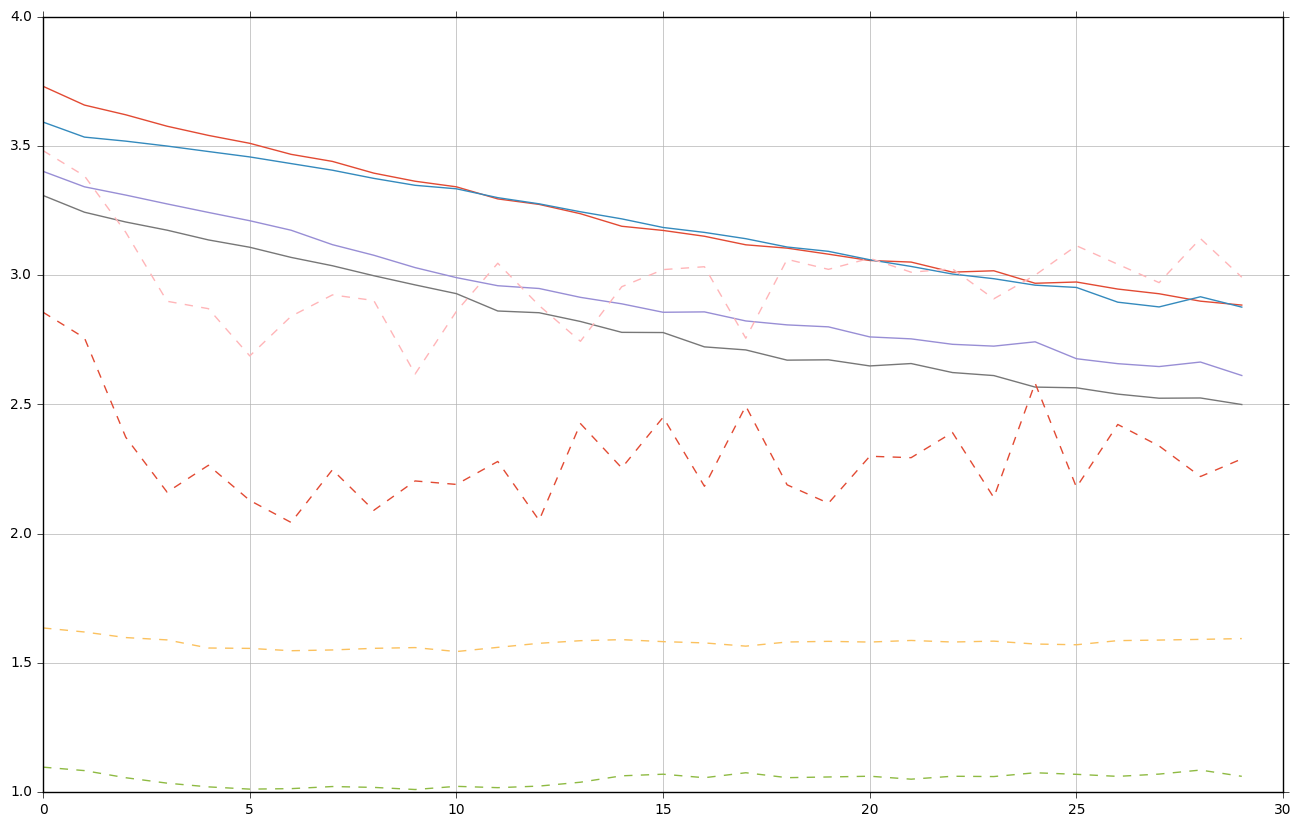

In [8]:
for history in hist:
    plt.plot(history.history['loss'])
for history in hist:
    plt.plot(history.history['val_loss'], linestyle = '--')
    
#fig = plt.figure(figsize=(7, 5), dpi=80, facecolor='w', edgecolor='k')
#ax = fig.add_subplot(1,1,1)
#ax.plot(np.array(hist[-2].history['loss']) / 60)
#ax.plot(np.array(hist[-2].history['val_loss']) / 60, linestyle = '--')
#plt.ylabel('loss (min)', fontsize = 14)
#plt.xlabel('epoch', fontsize = 14)
#plt.legend(['train', 'test'], loc='upper right')
#plt.show()
#fig.savefig('conv_lstm_model_loss.pdf')
#fig.close()